# Try on GBM method

In [1]:
import numpy as np
import pandas as pd
import json
from dscribe.descriptors import CoulombMatrix
from ase import Atoms
import matplotlib.pyplot as plt


test = pd.read_json('data/test.json')
train = pd.read_json('data/train.json')
## Transform atoms entry to ASE atoms object
train.atoms = train.atoms.apply(lambda x: Atoms(**x)) # OBS This one is important!
test.atoms = test.atoms.apply(lambda x: Atoms(**x))

species = []
number_of_atoms = []
atomic_numbers = []
for atom in pd.concat([train.atoms,test.atoms]):
    species = list(set(species+atom.get_chemical_symbols()))
    atomic_numbers = list(set(atomic_numbers+list(atom.get_atomic_numbers())))
    number_of_atoms.append(len(atom))

max_number_of_atoms = np.max(number_of_atoms)
min_atomic_number = np.min(atomic_numbers)
max_atomic_number = np.max(atomic_numbers)

In [2]:
# Setting up the CM descriptor
cm = CoulombMatrix(
    n_atoms_max=max_number_of_atoms,
)

cmats = np.zeros((len(train),max_number_of_atoms**2))
for i,atoms in enumerate(train.atoms):
    if i%1000 == 0:
        print(i)
    cmats[i,:] = cm.create(atoms)

0
1000
2000
3000
4000
5000
6000
7000


In [3]:
X = pd.DataFrame(data = cmats, index=train.id)
y = train['hform']
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (8000, 400)
y: (8000,)


In [4]:
from sklearn.decomposition import PCA
n_comp_PCA = 200

pca = PCA(n_components = n_comp_PCA).fit(X)
X_PCA = pca.transform(X)
print("With {} PCA components {var:0.4f}% of the variance is explained".format(n_comp_PCA, var = 100*np.sum(pca.explained_variance_ratio_)))
print('X_train: {}'.format(X_PCA.shape))

With 200 PCA components 99.9999% of the variance is explained
X_train: (8000, 200)


In [11]:
# Try with GBM
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.utils.fixes import parse_version
from sklearn.metrics import mean_squared_error as mse

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)



GradientBoostingRegressor(max_depth=10, min_samples_split=5, n_estimators=300)

In [22]:
n_v = [100,150,200,250,300,350,400,450,500]
depth = [1,4,7,10,13,15,17]
depth2 = [6,7,8]
split = [2,5,7,10,12]
learning = [0.01,0.1,0.3,0.5,0.7]

for i in range(1):
    params = {
        "n_estimators": 300,
        "max_depth": 7,
        "min_samples_split": 7,
        "learning_rate": 0.1,
        "loss": "squared_error",
    }

    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X_train, y_train)
    train_prediction = reg.predict(X_train)
    test_prediction = reg.predict(X_test)
    print(f'Learning = {i} ''Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
    print(f'Learning = {i} ''Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))

Learning = 0 Train RMSE = 0.08
Learning = 0 Test RMSE = 0.30


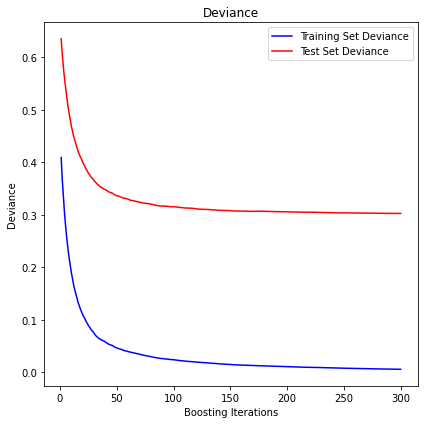

In [23]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = rmse(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()
